# Runoff in OM3

In ACCESS-OM3 runoff is prescribed from the DROF (Data Run Off) component and passed through to mediator to MOM6 (the ocean model). We can lose or gain water at each of these steps, but the goal is the total volume of runoff entering MOM6 is the same as the total volume of run whcih originated in the DROF.

In [1]:
EARTH_R = 3.71229E6

In [2]:
ROF_SOURCE_F = [
    '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.licalvf.1990_1991.nc', 
    '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.friver.1990_1991.nc',
    '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/ocean/fx/areacello/gr/v20190429/areacello_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr.nc' # area
]

In [3]:
ROF_MESH_F = '/g/data/vk83/configurations/inputs/access-om3/share/meshes/share/2024.09.16/JRA55do-drof-ESMFmesh.nc'

In [4]:
MODEL_MESH_F = '/g/data/vk83/experiments/inputs/access-om3/share/meshes/global.1deg/2024.01.25/access-om2-1deg-ESMFmesh.nc'

The experiment output used for demonstration:

In [5]:
ARCHIVE_DIR = '/g/data/tm70/as2285/payu/MOM6-CICE6/archive/'

In [6]:
cd {ARCHIVE_DIR}

/scratch/tm70/as2285/access-om3/archive/MOM6-CICE6


In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmpy
import cf_xarray

from intake import open_esm_datastore
from copy import copy
from dask.distributed import Client

In [8]:
client = Client(threads_per_worker=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35085 instead
  warnings.warn(


In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35085/status,
Dashboard: /proxy/35085/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45539,Workers: 12
Dashboard: /proxy/35085/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:45287,Total threads: 1
Dashboard: /proxy/44895/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:32961,


Open the DROF source data

In [10]:
ryf_runoff_ds = xr.open_mfdataset(ROF_SOURCE_F)

In [11]:
ryf_runoff_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (lat: 720, bnds: 2, lon: 1440, time: 365)
Coordinates:
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 3kB 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 12kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 23kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    areacello  (lat, lon) float32 4MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    friver     (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    licalvf    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/34)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-08T11:48:52Z
    data_specs_version:  01.00.29
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/29996f42-a99e-4762-8f11-24888d857e61
    variable_id:         areacello
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

To make this demonstration easier, some extra diagnostics were turned on.

These are:

- daily mom output of friver and ficeberg fields in the `diag_table`
- daily averages of mediator/coupler history for both rof and ocn components 

The configuration ran is https://github.com/ACCESS-NRI/access-om3-configs/commit/c0a05327bdc384ce3d9c625f6f485aab12e26c1c

For completeness, we'll also use the cell areas calculated by ESMF, although they should be the same as the mom cell areas:

In [12]:
rof_mesh = esmpy.Mesh(
    filename = ROF_MESH_F ,
    filetype=esmpy.FileFormat.ESMFMESH
)

--------------------------------------------------------------------------

  Local host:   gadi-cpu-clx-0438
  Local device: mlx5_0
--------------------------------------------------------------------------


In [13]:
rof_fld = esmpy.Field(
    rof_mesh,
    meshloc=esmpy.MeshLoc.ELEMENT
)
    

In [14]:
rof_fld.get_area()

In [15]:
rof_areas = copy(rof_fld.data.reshape(720,1440)*6.37122E6*6.37122E6)

In [16]:
model_mesh = esmpy.Mesh(
    filename= MODEL_MESH_F, 
    filetype=esmpy.FileFormat.ESMFMESH,
)

In [17]:
med_fld = esmpy.Field(
    model_mesh,
    meshloc=esmpy.MeshLoc.ELEMENT
)

In [18]:
med_fld.get_area()

In [19]:
med_areas = copy(med_fld.data.reshape(300,360)*6.37122E6*6.37122E6)

# DROF to Mediator

If we start from the source, want to compare the incoming run off from JRA to the runoff received by the mediator. This remaps from the JRA grid to the mediator grid (the same as the ocean grid in this case).

The mesh files are configured through the `meshfile` in `drof.streams.xml` for the DROF mesh, and `model_meshfile` in `drof_in` for the mediator

In [20]:
rof_med_files = ! ls output*/access-om3.cpl.ha.rof.*

rof_med_ds = xr.open_mfdataset(rof_med_files)

In [23]:
jra_runoff = ((ryf_runoff_ds.friver+ryf_runoff_ds.licalvf)*rof_areas).cf.sum(['X','Y'])

In [24]:
jra_licalvf_runoff = ((ryf_runoff_ds.licalvf)*rof_areas).cf.sum(['X','Y'])

In [25]:
jra_friver_runoff = ((ryf_runoff_ds.friver)*rof_areas).cf.sum(['X','Y'])

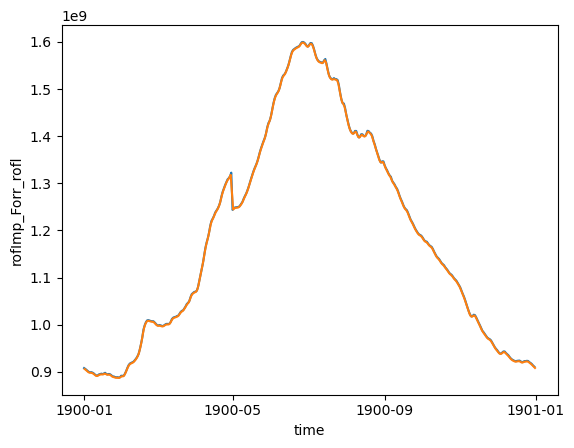

In [26]:
jra_friver_runoff.plot(label='jra55do')
(rof_med_ds.rofImp_Forr_rofl*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()


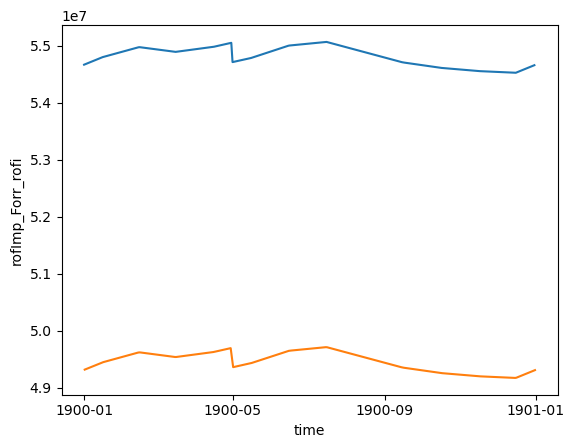

In [27]:
jra_licalvf_runoff.plot(label='jra55do')
(rof_med_ds.rofImp_Forr_rofi*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()


You can see we have less liquid run-off entering the mediator (orange-line) than exists in the DROF. This is because the access-om2 1degee grid starts at 78S however the DROF product has meltwater south of this location:

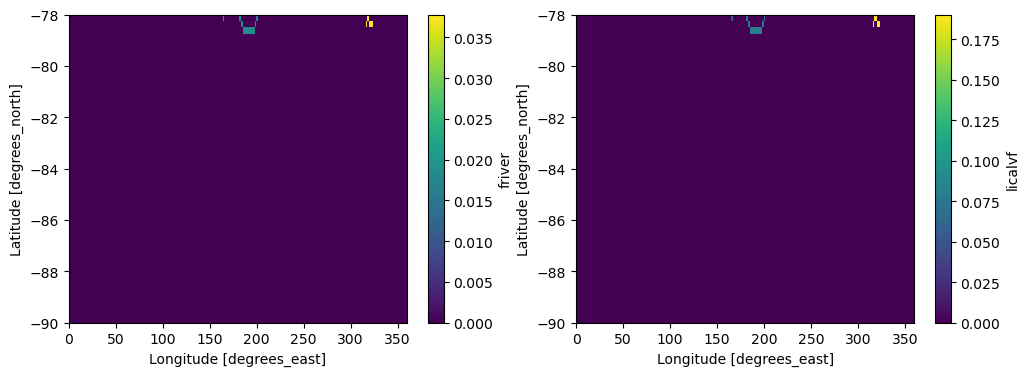

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ryf_runoff_ds.sum('time').friver.sel(lat=slice(None,-78)).plot()
plt.subplot(1,2,2)
ryf_runoff_ds.sum('time').licalvf.sel(lat=slice(None,-78)).plot()

If we remove the meltwater south of 78S, then the match is closer:

In [29]:
jra_licalvf_runoff = ((ryf_runoff_ds.licalvf)*rof_areas).sel(lat=slice(-78,None)).cf.sum(['X','Y'])

In [30]:
jra_friver_runoff = ((ryf_runoff_ds.friver)*rof_areas).sel(lat=slice(-78,None)).cf.sum(['X','Y'])

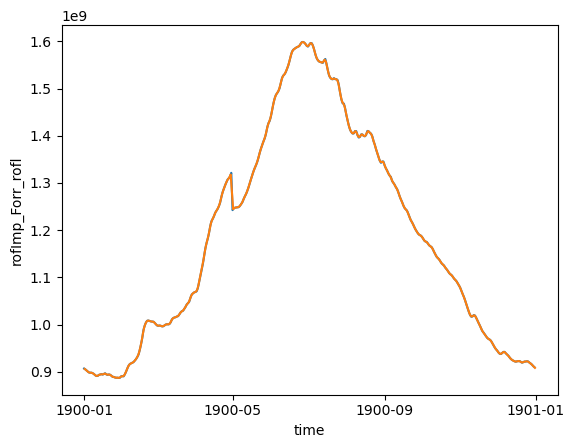

In [31]:
jra_friver_runoff.plot(label='jra55do')
(rof_med_ds.rofImp_Forr_rofl*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()


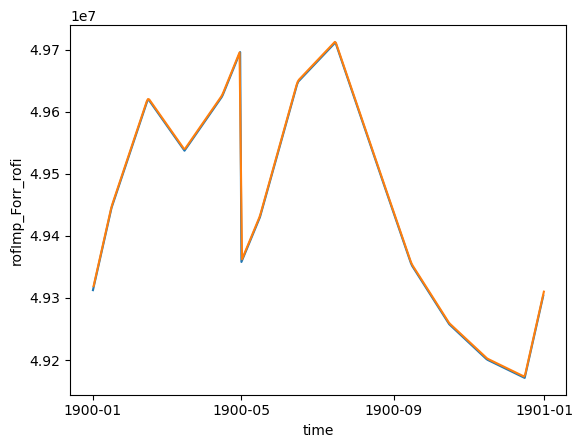

In [32]:
jra_licalvf_runoff.plot(label='jra55do')
(rof_med_ds.rofImp_Forr_rofi*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()


Whilst we are here, we can compare the cell areas used by the mediator to those provided by the data product:

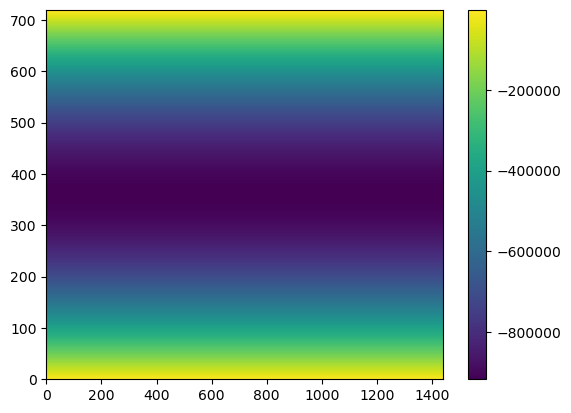

In [33]:
plt.pcolor(rof_areas-ryf_runoff_ds.areacello.values)
plt.colorbar()

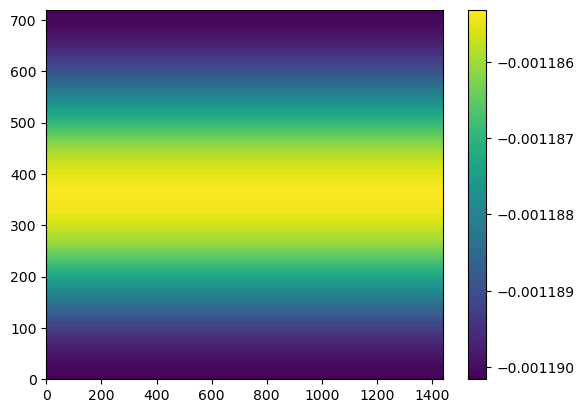

In [34]:
plt.pcolor((rof_areas-ryf_runoff_ds.areacello.values)/rof_areas)
plt.colorbar()

They are not totally identical. The ones in the data product are about 0.12% smaller. Which should be inconsequential.

# Mediator to mediator

Note the configuration here on the DROF doesn't have any awareness of the ocean/land mask. It just maps from any cell to any cell. We use the mediator remapping step to moved all runoff into ocean cells, so the ocn model receives the same overall volume of runoff that is received by the mediator.

(The mediator remapping step is a little strange in our case. The mediator uses the same mesh as the ocean, so there is nothing to regrid, however we use the remapping weights to move an runoff going to land cells to go to ocean cells.)

The mesh files are `mesh_rof` in `nuopc.runconfig` for the incoming field, and `mesh_ocn` in the same file for the outgoing field.

In [35]:
ocn_med_files = ! ls output*/access-om3.cpl.ha.ocn.*

ocn_med_ds = xr.open_mfdataset(ocn_med_files)

First check the overall volumes

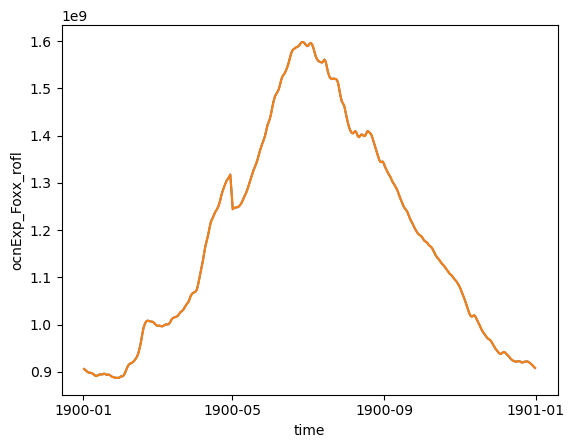

In [36]:
(rof_med_ds.rofImp_Forr_rofl*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()
(ocn_med_ds.ocnExp_Foxx_rofl*med_areas).sum(['ocnExp_ny','ocnExp_nx']).plot()

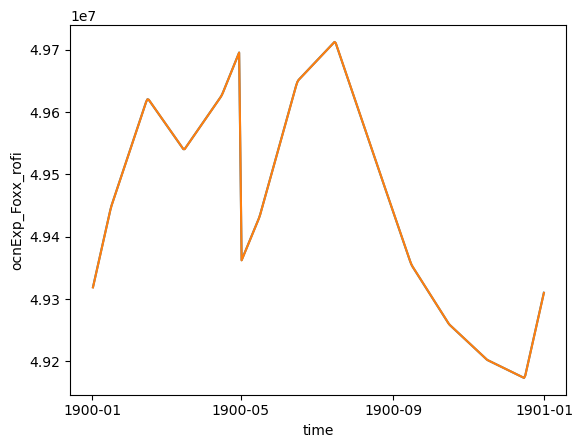

In [37]:
(rof_med_ds.rofImp_Forr_rofi*med_areas).sum(['rofImp_ny','rofImp_nx']).plot()
(ocn_med_ds.ocnExp_Foxx_rofi*med_areas).sum(['ocnExp_ny','ocnExp_nx']).plot()

And the difference in location of the outgoing vs incoming runoff

In [38]:
mod_mesh_ds = xr.open_dataset(MODEL_MESH_F)

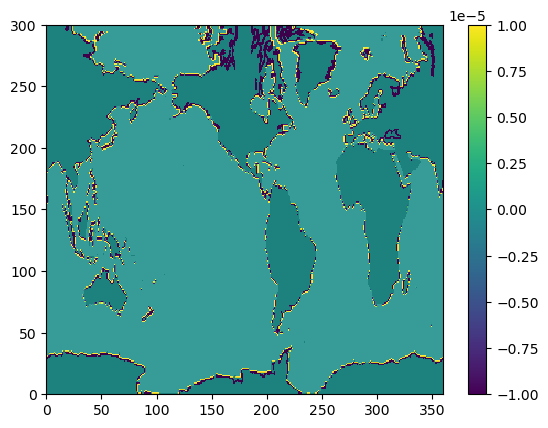

In [51]:
plt.pcolor(ocn_med_ds.ocnExp_Foxx_rofl.sum('time').values - rof_med_ds.rofImp_Forr_rofl.sum('time').values, vmin = -1e-5, vmax = 1e-5, cmap='viridis')
plt.colorbar()
plt.pcolormesh(mod_mesh_ds.elementMask.values.reshape(300,360), cmap='grey', alpha=0.1)


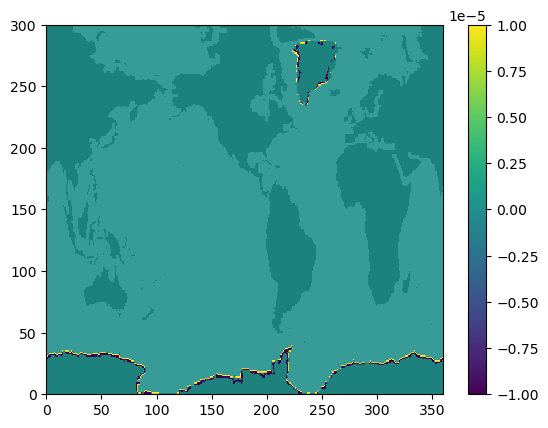

In [53]:
plt.pcolor(ocn_med_ds.ocnExp_Foxx_rofi.sum('time').values - rof_med_ds.rofImp_Forr_rofi.sum('time').values, vmin = -1e-5, vmax = 1e-5, cmap='viridis')
plt.colorbar()
plt.pcolormesh(mod_mesh_ds.elementMask.values.reshape(300,360), cmap='grey', alpha=0.1)


# Mediator to OCN

There is no remapping at this step, it relies on the `ocn_mesh` file and the MOM grid being the same (with the exception that the MOM6 Nuopc cap will correct for differences in cell area between the ocn_mesh and MOM grid).

In [41]:
om3_ds = open_esm_datastore(
    f'{ARCHIVE_DIR}/intake_esm_ds.json', 
    columns_with_iterables=['variable','variable_long_name','variable_standard_name'])

In [42]:
mom_frof_ds = om3_ds.search(variable=['friver', 'ficeberg']).to_dask()

In [43]:
mom_frof_ds

<xarray.Dataset> Size: 315MB
Dimensions:   (time: 365, yh: 300, xh: 360)
Coordinates:
  * time      (time) object 3kB 1900-01-01 12:00:00 ... 1900-12-31 12:00:00
  * yh        (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * xh        (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    ficeberg  (time, yh, xh) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    friver    (time, yh, xh) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    MOM6 diagnostic fields table
    associated_files:                         areacello: access-om3.mom6.h.st...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['ficeberg', 'friver']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  sea_water_salinity,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ['time: mean', 'time: mean', 'z...
    intake_esm_attrs:variable_units:          ['psu', 'degC', 'm3 s-1', 'm3 s...
    intake_esm_attrs:file_id:                 access_om3_mom6_h_nativeXXXX_XX
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_h_nativeXXXX_XX...

In [44]:
mom_area = xr.open_dataset(om3_ds.search(variable='areacello').df.path[0])

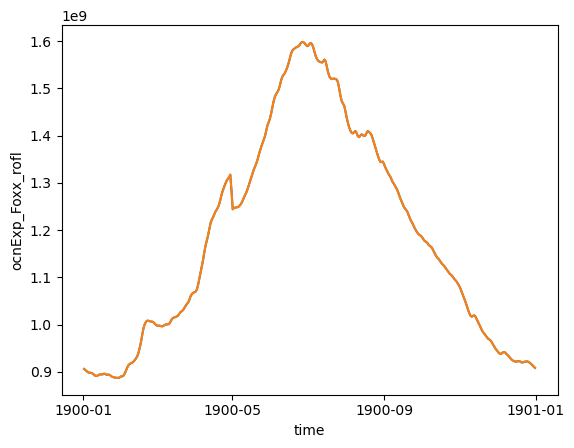

In [54]:
(mom_frof_ds.friver * mom_area.areacello).sum(['xh','yh']).plot()
(ocn_med_ds.ocnExp_Foxx_rofl*med_areas).sum(['ocnExp_ny','ocnExp_nx']).plot()

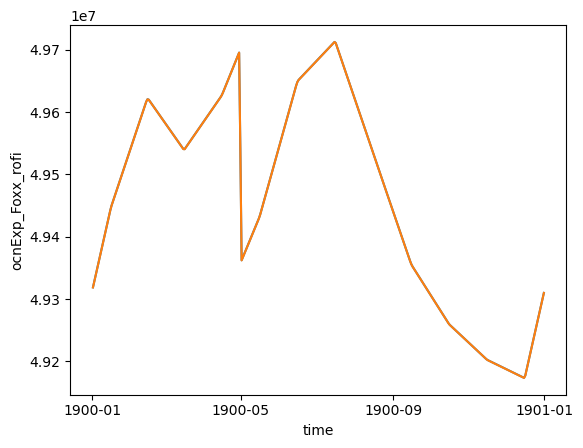

In [55]:
(mom_frof_ds.ficeberg * mom_area.areacello).sum(['xh','yh']).plot()
(ocn_med_ds.ocnExp_Foxx_rofi*med_areas).sum(['ocnExp_ny','ocnExp_nx']).plot()

And compare areas, shows only minor differences at the geographic north pole:

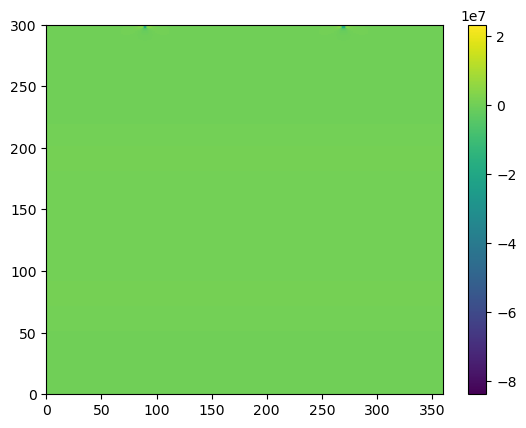

In [56]:
plt.pcolor(med_areas - mom_area.areacello.values)
plt.colorbar()

# And end to end ?

In [58]:
mom_frunin_total = ((mom_frof_ds.friver+mom_frof_ds.ficeberg) * mom_area.areacello).sum(['xh','yh'])

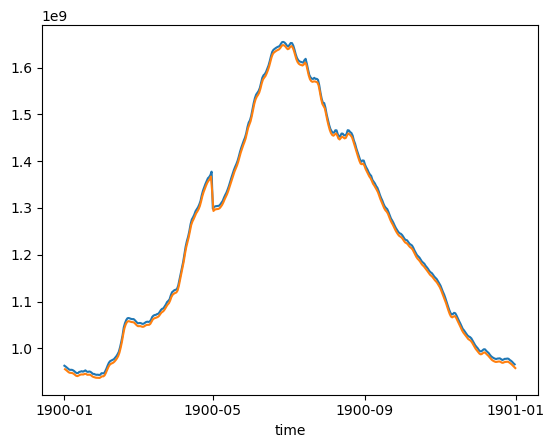

In [59]:
jra_runoff.plot(label='jra55do')
mom_frunin_total.plot(label='mom6')

And excluding the runoff south of 78S:

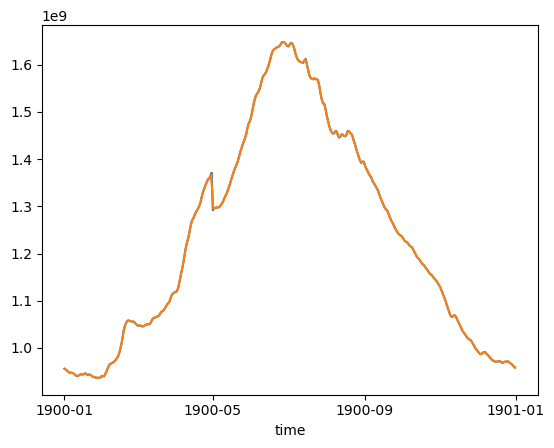

In [60]:
(jra_friver_runoff+jra_licalvf_runoff).plot(label='jra55do')
mom_frunin_total.plot(label='mom6')

In [61]:
client.close()